# Proyecto A - Caso Base

Vamos a abordar desafíos inherentes a la alta densidad de tráfico, restricciones de espacio en entornos urbanos, el alto volumen de entregas.

Este modelo básico de CVRP tiene un único centro de distribución y vehículos homogéneos.


# Configuraciones iniciales

In [1]:
!pip install -q pyomo
!pip install -q highspy

In [2]:
import pandas as pd
import folium
import math
import pyomo.environ as pyo
from pyomo.opt import SolverFactory

# Carga de datos

Teniendo la carpeta Proyecto_Caso_Base cargamos uno por uno cada archivo csv.

In [3]:
# Cargar archivos
df_clients = pd.read_csv("clients.csv")
df_vehicles = pd.read_csv("vehicles.csv")
df_depots = pd.read_csv("depots.csv")

# Preparación y formateo de los datos

In [4]:
depot_lat = float(df_depots.iloc[0]["Latitude"])
depot_lon = float(df_depots.iloc[0]["Longitude"])
depot_id = "CD01"

# Diccionarios de datos
clients = {r["StandardizedID"]: {"lat": r["Latitude"], "lon": r["Longitude"], "demand": r["Demand"]} for _, r in df_clients.iterrows()}
vehicles = {r["StandardizedID"]: {"cap": r["Capacity"], "range": r["Range"]} for _, r in df_vehicles.iterrows()}

all_nodes = [depot_id] + list(clients.keys())
customers = list(clients.keys())
veh_ids = list(vehicles.keys())

In [5]:
# Función Haversine
def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    phi1, phi2 = math.radians(lat1), math.radians(lat2)
    dphi, dlambda = math.radians(lat2 - lat1), math.radians(lon2 - lon1)
    a = math.sin(dphi/2)**2 + math.cos(phi1)*math.cos(phi2) * math.sin(dlambda/2)**2
    return 2 * R * math.asin(math.sqrt(a))

# Calcular TODAS las distancias primero
dist = {}
for i in all_nodes:
    lat_i = depot_lat if i == depot_id else clients[i]["lat"]
    lon_i = depot_lon if i == depot_id else clients[i]["lon"]
    for j in all_nodes:
        if i == j:
            dist[i, j] = 0.0
            continue
        lat_j = depot_lat if j == depot_id else clients[j]["lat"]
        lon_j = depot_lon if j == depot_id else clients[j]["lon"]
        dist[i, j] = haversine(lat_i, lon_i, lat_j, lon_j)

# Parametros generales

In [6]:
SPEED_KMPH = 40.0
FUEL_PRICE = 16300.0      # COP/gal
FUEL_EFF   = 30.0         # km/gal
DRIVER_COST= 7600.0       # COP/hora
MAINT_COST = 2500.0       # COP/km
FIXED_COST = 50000.0      # COP por vehículo
COST_PER_KM = (FUEL_PRICE / FUEL_EFF) + MAINT_COST + (DRIVER_COST / SPEED_KMPH)

# Optimización clave

Vamos a reducir los arcos (Neighborhood search) para que no se tomen en cuenta distancias muy largas en la resolución.

In [7]:
# Solo permitimos viajar desde 'i' a sus N vecinos más cercanos (y al depósito)
valid_arcs = set()
N_NEIGHBORS = 12

for i in all_nodes:
    # Ordenar todos los destinos j por distancia desde i
    neighbors = sorted([n for n in all_nodes if n != i], key=lambda x: dist[i, x])

    # Mantener siempre el depósito y los N más cercanos
    keep = set(neighbors[:N_NEIGHBORS])
    keep.add(depot_id) # Siempre se puede ir/volver al depósito

    for j in keep:
        valid_arcs.add((i, j))

print(f"Arcos reducidos de {len(all_nodes)**2} a {len(valid_arcs)} para acelerar.")

Arcos reducidos de 625 a 319 para acelerar.


# Modelado Pyomo Optimizado

Vamos a definir cada conjunto, variables de decisión y función objetivo. Luego, crearemos funciones por cada restricción.

In [8]:
m = pyo.ConcreteModel()

# Conjuntos
m.N = pyo.Set(initialize=all_nodes)
m.C = pyo.Set(initialize=customers)
m.V = pyo.Set(initialize=veh_ids)
m.A = pyo.Set(initialize=list(valid_arcs), dimen=2)

# Variables
m.x = pyo.Var(m.V, m.A, domain=pyo.Binary)
m.u = pyo.Var(m.V, m.N, domain=pyo.NonNegativeReals)
m.y = pyo.Var(m.V, domain=pyo.Binary)

# Objetivo
m.Obj = pyo.Objective(
    rule=lambda model: sum(FIXED_COST * model.y[v] for v in model.V) +
                       sum(dist[i,j] * COST_PER_KM * model.x[v,i,j] for v in model.V for (i,j) in model.A),
    sense=pyo.minimize)

In [9]:
# Restricciones
# 1. Visitar clientes
def visit_rule(model, c):
    return sum(model.x[v, i, c] for v in model.V for i in model.N if (i, c) in model.A) == 1
m.Visit = pyo.Constraint(m.C, rule=visit_rule)

# 2. Flujo
def flow_rule(model, v, n):
    incoming = sum(model.x[v, i, n] for i in model.N if (i, n) in model.A)
    outgoing = sum(model.x[v, n, j] for j in model.N if (n, j) in model.A)
    return incoming == outgoing
m.Flow = pyo.Constraint(m.V, m.N, rule=flow_rule)

# 3. Depot Start
def depot_start(model, v):
    return sum(model.x[v, depot_id, j] for j in model.C if (depot_id, j) in model.A) == model.y[v]
m.DepotStart = pyo.Constraint(m.V, rule=depot_start)

# 4. MTZ Capacidad (CORREGIDA)
def capacity_mtz(model, v, i, j):
    # CORRECCIÓN: Si el destino 'j' es el depósito, saltamos la restricción
    # porque el depósito no tiene demanda en el diccionario 'clients'
    # y no necesitamos acumular carga al final de la ruta.
    if i == depot_id or j == depot_id: return pyo.Constraint.Skip

    return model.u[v, j] >= model.u[v, i] + clients[j]["demand"] - vehicles[v]["cap"] * (1 - model.x[v, i, j])
m.CapMTZ = pyo.Constraint(m.V, m.A, rule=capacity_mtz)

# 5. Límites Carga
def load_limit(model, v, i):
    if i == depot_id: return pyo.Constraint.Skip
    return model.u[v, i] <= vehicles[v]["cap"]
m.LoadLimit = pyo.Constraint(m.V, m.C, rule=load_limit)

# 6. Carga Inicial
def init_load(model, v, j):
    if (depot_id, j) not in model.A: return pyo.Constraint.Skip
    return model.u[v, j] >= clients[j]["demand"] * model.x[v, depot_id, j]
m.InitLoad = pyo.Constraint(m.V, m.C, rule=init_load)

# 7. Rango
def range_rule(model, v):
    return sum(dist[i,j] * model.x[v,i,j] for (i,j) in model.A) <= vehicles[v]["range"]
m.Range = pyo.Constraint(m.V, rule=range_rule)

# Resolución del problema

Se usará el solver Highs, además, se establecerá un tiempo límite para que no quede iterando.

In [10]:
print("Resolviendo versión optimizada...")
solver = SolverFactory("appsi_highs")
solver.options = {
    'time_limit': 600,
    'mip_rel_gap': 0.05
}
res = solver.solve(m, tee=True)

Resolviendo versión optimizada...
Running HiGHS 1.12.0 (git hash: 755a8e0): Copyright (c) 2025 HiGHS under MIT licence terms
MIP has 2784 rows; 2752 cols; 17240 nonzeros; 2560 integer variables (2560 binary)
Coefficient ranges:
  Matrix  [3e-01, 1e+02]
  Cost    [1e+03, 7e+04]
  Bound   [1e+00, 1e+00]
  RHS     [1e+00, 2e+02]
Presolving model
2592 rows, 2744 cols, 17048 nonzeros  0s
2592 rows, 2744 cols, 16904 nonzeros  0s
Presolve reductions: rows 2592(-192); columns 2744(-8); nonzeros 16904(-336) 

Solving MIP model with:
   2592 rows
   2744 cols (2552 binary, 0 integer, 0 implied int., 192 continuous, 0 domain fixed)
   16904 nonzeros

Src: B => Branching; C => Central rounding; F => Feasibility pump; H => Heuristic;
     I => Shifting; J => Feasibility jump; L => Sub-MIP; P => Empty MIP; R => Randomized rounding;
     S => Solve LP; T => Evaluate node; U => Unbounded; X => User solution; Y => HiGHS solution;
     Z => ZI Round; l => Trivial lower; p => Trivial point; u => Trivial 

     19232    1032      2432  12.59%   237485.55074    832972.335737     71.49%     2537    298   9932     1215k   600.0s

Solving report
  Status            Time limit reached
  Primal bound      832972.335737
  Dual bound        237485.55074
  Gap               71.49% (tolerance: 5%)
  P-D integral      473.927627981
  Solution status   feasible
                    832972.335737 (objective)
                    0 (bound viol.)
                    0 (int. viol.)
                    0 (row viol.)
  Timing            600.01
  Max sub-MIP depth 5
  Nodes             19232
  Repair LPs        0
  LP iterations     1215143
                    416105 (strong br.)
                    74592 (separation)
                    66904 (heuristics)


# Reporte pedido en el enunciado

Se generará el archivo de verificación de la solución óptima.

In [11]:
# REPORTE

if res.solver.termination_condition in [pyo.TerminationCondition.optimal, pyo.TerminationCondition.maxTimeLimit]:
    output_rows = []
    for v in veh_ids:
        if pyo.value(m.y[v]) > 0.5:
            route = [depot_id]
            curr = depot_id
            while True:
                found = False
                for j in all_nodes:
                    if (curr, j) in valid_arcs and pyo.value(m.x[v, curr, j]) > 0.5:
                        curr = j
                        route.append(curr)
                        found = True
                        break
                if not found or curr == depot_id: break

            # Datos fila
            served = [c for c in route if c != depot_id]
            dist_km = sum(dist[route[i], route[i+1]] for i in range(len(route)-1))
            output_rows.append({
                "VehicleId": v, "DepotId": depot_id,
                "InitialLoad": int(sum(clients[c]["demand"] for c in served)),
                "RouteSequence": "-".join(route),
                "ClientsServed": len(served),
                "DemandsSatisfied": "-".join([str(int(clients[c]["demand"])) for c in served]),
                "TotalDistance": round(dist_km, 1),
                "TotalTime": round((dist_km/SPEED_KMPH)*60, 1),
                "FuelCost": int((dist_km/FUEL_EFF)*FUEL_PRICE)
            })

    df_out = pd.DataFrame(output_rows)[["VehicleId", "DepotId", "InitialLoad", "RouteSequence",
                                        "ClientsServed", "DemandsSatisfied", "TotalDistance", "TotalTime", "FuelCost"]]
    df_out.to_csv("verificacion_caso1.csv", index=False)
    print("\n¡Listo! Archivo 'verificacion_caso1.csv' generado.")
    print(df_out[["VehicleId", "RouteSequence", "TotalDistance"]])
else:
    print("No se encontró solución factible aún.")


¡Listo! Archivo 'verificacion_caso1.csv' generado.
  VehicleId                                      RouteSequence  TotalDistance
0      V001  CD01-C013-C004-C024-C016-C010-C017-C011-C001-CD01           66.7
1      V003                 CD01-C002-C021-C007-C022-C006-CD01           50.8
2      V004                 CD01-C005-C009-C015-C018-C008-CD01           44.9
3      V008            CD01-C023-C012-C020-C014-C019-C003-CD01           33.4


# Visualización de resultados

Veremos un mapa interactivo con Folium de las rutas que se obtuvieron en la optimización.

In [12]:
# Crear diccionario de Coordenadas y Metadatos
# Para buscar rápido la lat/lon de cualquier nodo (C001, CD01, etc.)
nodes = {}

# Agregar Depósito
depot_row = df_depots.iloc[0]
# Ajuste según nombres de columnas en tu archivo depots.csv
nodes["CD01"] = {
    "lat": float(depot_row["Latitude"]),
    "lon": float(depot_row["Longitude"]),
    "type": "Depot",
    "info": "Centro de Distribución"
}

# Agregar Clientes
for _, row in df_clients.iterrows():
    nodes[row["StandardizedID"]] = {
        "lat": float(row["Latitude"]),
        "lon": float(row["Longitude"]),
        "type": "Client",
        "info": f"Demanda: {row['Demand']} kg"
    }

In [13]:
# Configuración del Mapa
# Centramos el mapa en el depósito de Bogotá
map_center = [nodes["CD01"]["lat"], nodes["CD01"]["lon"]]
m = folium.Map(location=map_center, zoom_start=12, tiles="CartoDB positron")

# Colores para distinguir cada vehículo
colors = ['blue', 'green', 'purple', 'orange', 'red', 'darkblue', 'cadetblue', 'darkgreen']

In [15]:
# Dibujar Rutas
for idx, row in df_out.iterrows():
    veh_id = row["VehicleId"]
    route_str = row["RouteSequence"]
    dist = row["TotalDistance"]
    load = row["InitialLoad"]

    # Convertir string "CD01-C001-CD01" a lista de códigos
    node_ids = route_str.split('-')

    # Obtener lista de coordenadas para la polilínea
    route_coords = []
    try:
        for nid in node_ids:
            route_coords.append([nodes[nid]["lat"], nodes[nid]["lon"]])
    except KeyError as e:
        print(f"Error: Nodo {e} no encontrado en clients/depots. Verifica los IDs.")
        continue

    # Asignar color (cíclico si hay muchos vehículos)
    color = colors[idx % len(colors)]

    # Crear Grupo para poder apagar/prender rutas en el mapa
    feature_group = folium.FeatureGroup(name=f"{veh_id} (Carga: {load}kg)")

    # Trazar la línea de la ruta
    folium.PolyLine(
        route_coords,
        color=color,
        weight=4,
        opacity=0.7,
        tooltip=f"{veh_id}: {dist} km"
    ).add_to(feature_group)

    # Añadir marcadores para los clientes de esta ruta
    # Omitimos el depósito aquí para dibujarlo una sola vez al final
    for i, nid in enumerate(node_ids):
        if nodes[nid]["type"] == "Client":
            folium.CircleMarker(
                location=[nodes[nid]["lat"], nodes[nid]["lon"]],
                radius=5,
                color=color,
                fill=True,
                fill_color=color,
                fill_opacity=1.0,
                popup=folium.Popup(f"<b>{nid}</b><br>{nodes[nid]['info']}", max_width=200)
            ).add_to(feature_group)

            # Opcional: Añadir pequeño texto con el número de orden de visita
            # (Puede saturar el mapa, descomentar si se desea)
            # folium.Marker(
            #     [nodes[nid]["lat"], nodes[nid]["lon"]],
            #     icon=folium.DivIcon(html=f'<div style="font-size: 10pt; color: {color};"><b>{i}</b></div>')
            # ).add_to(feature_group)

    feature_group.add_to(m)

In [16]:
# Dibujar el Depósito (CD01) destacado
folium.Marker(
    location=[nodes["CD01"]["lat"], nodes["CD01"]["lon"]],
    icon=folium.Icon(color="black", icon="home", prefix="fa"),
    popup="<b>CD01</b><br>Centro de Distribución",
    tooltip="Depósito Central"
).add_to(m)

# Añadir control de capas
folium.LayerControl().add_to(m)

# Guardar y Mostrar
output_file = "mapa_rutas_caso1.html"
m.save(output_file)
print(f"Mapa guardado como '{output_file}'. Descárgalo para verlo en pantalla completa.")

# Mostrar
m

Mapa guardado como 'mapa_rutas_caso1.html'. Descárgalo para verlo en pantalla completa.


# Gráficos estáticos

**Mapa de Rutas (grafico_mapa_rutas.png):**

 Muestra visualmente que las rutas son "cerradas" (empiezan y terminan en el cuadrado negro CD01) y que no hay cruces caóticos, cumpliendo con los requisitos de análisis visual.

**Nivel de Ocupación (grafico_capacidad.png):**

 Este es crucial. Muestra qué tan eficiente es tu solución. Verás porcentajes altos (ej. 90% o 95%), lo que demuestra al profesor que el algoritmo optimizó bien el espacio en los camiones (requisito ).

**Distancias (grafico_distancias.png):**

 Permite ver el balance de trabajo entre conductores.

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Diccionarios auxiliares para coordenadas y capacidades
coords = {}
# Depósito
depot_row = df_depots.iloc[0]
coords["CD01"] = (float(depot_row["Longitude"]), float(depot_row["Latitude"]))

# Clientes
for _, row in df_clients.iterrows():
    coords[row["StandardizedID"]] = (float(row["Longitude"]), float(row["Latitude"]))
# Capacidades de vehículos (para el gráfico de barras)
veh_caps = {}
for _, row in df_vehicles.iterrows():
    veh_caps[row["StandardizedID"]] = float(row["Capacity"])

# Configuración de estilo
sns.set_theme(style="whitegrid")
palette = sns.color_palette("bright", n_colors=len(df_out))

Generado: grafico_mapa_rutas.png y .pdf


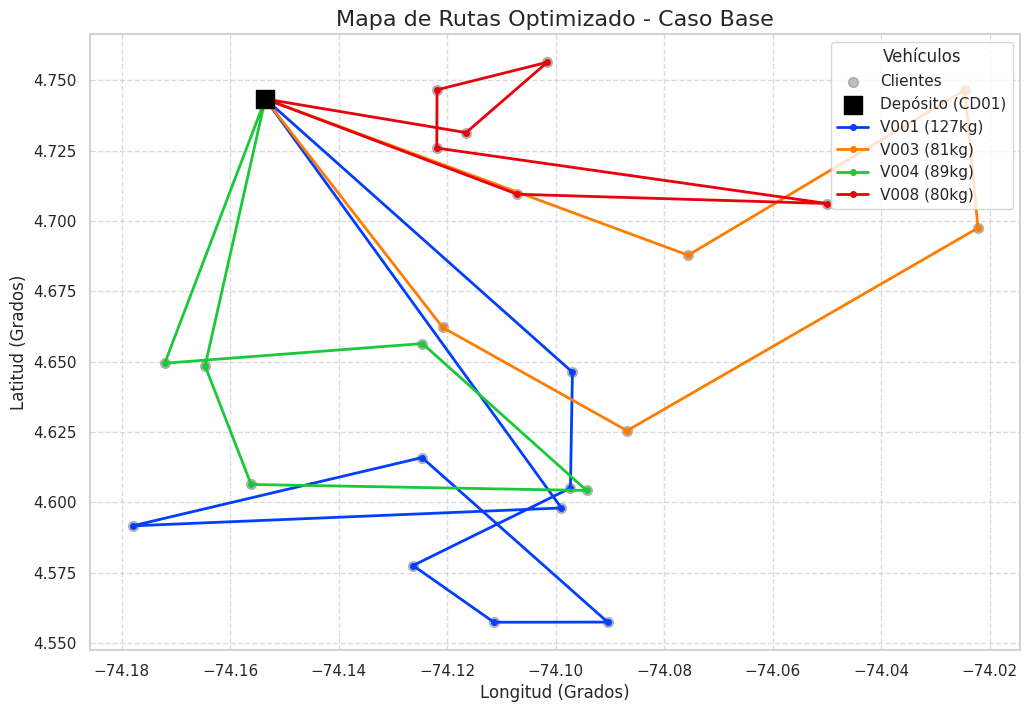

In [24]:
# ==========================================
# GRÁFICO 1: MAPA DE RUTAS (Plano 2D)
# ==========================================
plt.figure(figsize=(12, 8))
plt.title("Mapa de Rutas Optimizado - Caso Base", fontsize=16)
plt.xlabel("Longitud (Grados)", fontsize=12)
plt.ylabel("Latitud (Grados)", fontsize=12)

# 1. Dibujar Clientes (puntos grises) y Depósito (Cuadrado negro)
lons_c = [coords[c][0] for c in coords if c != "CD01"]
lats_c = [coords[c][1] for c in coords if c != "CD01"]
plt.scatter(lons_c, lats_c, c='gray', alpha=0.5, s=50, label='Clientes')
plt.scatter(coords["CD01"][0], coords["CD01"][1], c='black', marker='s', s=150, label='Depósito (CD01)', zorder=10)

# 2. Trazar Rutas
for idx, row in df_out.iterrows():
    vid = row["VehicleId"]
    route_ids = row["RouteSequence"].split('-')

    # Obtener coordenadas de la secuencia
    route_x = [coords[nid][0] for nid in route_ids]
    route_y = [coords[nid][1] for nid in route_ids]

    # Dibujar línea
    plt.plot(route_x, route_y, marker='o', markersize=4, linewidth=2,
             label=f"{vid} ({row['InitialLoad']}kg)", color=palette[idx])

plt.legend(loc='upper right', title="Vehículos")
plt.grid(True, linestyle='--', alpha=0.7)

# Guardar
plt.savefig("grafico_mapa_rutas.png", dpi=300, bbox_inches='tight')
plt.savefig("grafico_mapa_rutas.pdf", bbox_inches='tight')
print("Generado: grafico_mapa_rutas.png y .pdf")
plt.show()

/tmp/ipython-input-1955474135.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Vehículo', y='Carga Ocupada', data=df_cap, palette="viridis", label='Carga Ocupada')


Generado: grafico_capacidad.png y .pdf


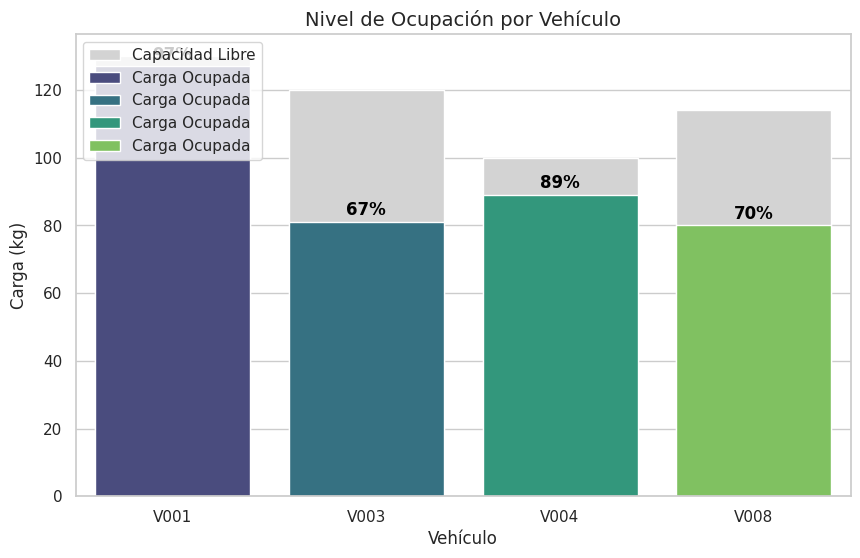

In [25]:
# ==========================================
# GRÁFICO 2: USO DE CAPACIDAD (Barras)
# ==========================================
plt.figure(figsize=(10, 6))

# Preparar datos
capacities = [veh_caps[v] for v in df_out["VehicleId"]]
loads = df_out["InitialLoad"].tolist()
vids = df_out["VehicleId"].tolist()

# Crear DataFrame temporal para seaborn
df_cap = pd.DataFrame({
    'Vehículo': vids,
    'Carga Ocupada': loads,
    'Capacidad Total': capacities
})

# Dibujar capacidad total (fondo gris claro)
sns.barplot(x='Vehículo', y='Capacidad Total', data=df_cap, color='lightgray', label='Capacidad Libre')
# Dibujar carga real (color superpuesto)
barplot = sns.barplot(x='Vehículo', y='Carga Ocupada', data=df_cap, palette="viridis", label='Carga Ocupada')

# Etiquetas de porcentaje
for i, p in enumerate(barplot.patches[len(df_out):]): # Iterar sobre las barras de carga (segunda mitad)
    height = p.get_height()
    cap = capacities[i]
    percent = (height / cap) * 100
    plt.text(p.get_x() + p.get_width()/2., height + 2,
             f'{int(percent)}%', ha="center", color='black', fontweight='bold')

plt.title("Nivel de Ocupación por Vehículo", fontsize=14)
plt.ylabel("Carga (kg)")
plt.legend(loc="upper left")

# Guardar
plt.savefig("grafico_capacidad.png", dpi=300, bbox_inches='tight')
plt.savefig("grafico_capacidad.pdf", bbox_inches='tight')
print("Generado: grafico_capacidad.png y .pdf")
plt.show()

/tmp/ipython-input-171208364.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="VehicleId", y="TotalDistance", data=df_out, palette="viridis")


Generado: grafico_distancias.png y .pdf


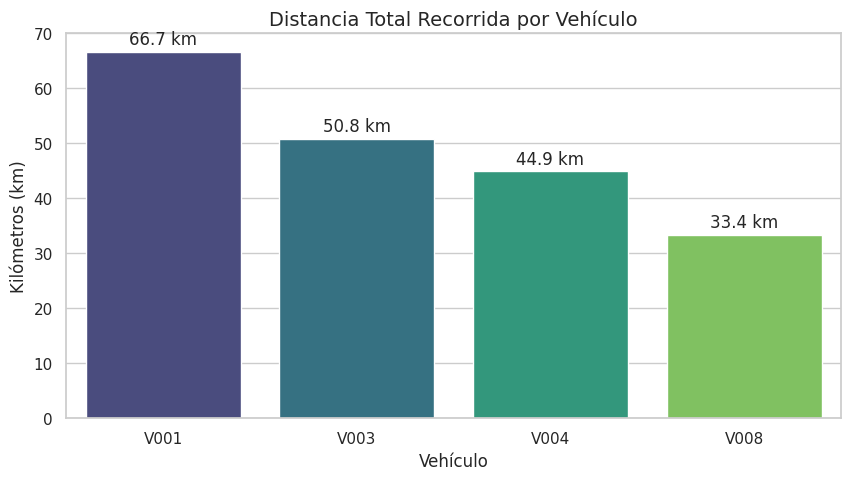

In [22]:
# ==========================================
# GRÁFICO 3: DISTANCIAS RECORRIDAS
# ==========================================
plt.figure(figsize=(10, 5))
ax = sns.barplot(x="VehicleId", y="TotalDistance", data=df_out, palette="viridis")

plt.title("Distancia Total Recorrida por Vehículo", fontsize=14)
plt.ylabel("Kilómetros (km)")
plt.xlabel("Vehículo")

# Poner el valor encima de la barra
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f} km',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points')

# Guardar
plt.savefig("grafico_distancias.png", dpi=300, bbox_inches='tight')
plt.savefig("grafico_distancias.pdf", bbox_inches='tight')
print("Generado: grafico_distancias.png y .pdf")
plt.show()